In [123]:
# Import Libraries
import os # for opearating system interaction
import pandas as pd # for working with tabular data 
import geopandas as gp # for GIS analysis
from shapely.geometry import Point # Allows the creation of gpkg files from xy data
import numpy as np # numerical calculation
from matplotlib import pyplot as plt # for plotting
import matplotlib

In [ ]:
#Load the datasets
tx_2022 = pd.read_csv("G:\\Mini project\\NBI_TX_2022.csv")
tx_2023 = pd.read_csv("G:\\Mini project\\NBI_TX_2023.csv")

In [125]:
# Function to convert DMS to Decimal Degrees and adjust based on WGS 84 for Texas
def dms_to_dd(dms_value, is_latitude=True):
    degrees = int(dms_value / 1000000)
    minutes = int((dms_value - degrees * 1000000) / 10000)
    seconds = (dms_value - degrees * 1000000 - minutes * 10000) / 100
    
    decimal_degrees = degrees + (minutes / 60) + (seconds / 3600)
    
    # For latitudes, positive in the northern hemisphere
    if is_latitude:
        return decimal_degrees  # Texas is in the northern hemisphere, so positive latitude
    
    # For longitudes, negative in the western hemisphere
    else:
        return -decimal_degrees  # Texas is in the western hemisphere, so negative longitude

In [126]:
# Merge datasets on the structure number, with left join to keep all 2023 bridges
merged_bridges = pd.merge(tx_2023, tx_2022, on='STRUCTURE_NUMBER_008', how='left', indicator=True)

In [127]:
# Find bridges that are in 2023 but not in 2022
new_bridges_2023 = tx_2023[~tx_2023['STRUCTURE_NUMBER_008'].isin(tx_2022['STRUCTURE_NUMBER_008'])]

In [ ]:
# Convert latitude and longitude from DMS to Decimal Degrees with proper sign
new_bridges_2023['LAT_016_dd'] = new_bridges_2023['LAT_016'].apply(lambda x: dms_to_dd(x, is_latitude=True))
new_bridges_2023['LONG_017_dd'] = new_bridges_2023['LONG_017'].apply(lambda x: dms_to_dd(x, is_latitude=False))

In [138]:
# Filter for bridges that are in 2023 but not in 2022 (i.e., those that are only in the left table)
new_bridges_2023 = merged_bridges[merged_bridges['_merge'] == 'left_only']

In [130]:
# Drop rows with missing latitude or longitude after conversion
new_bridges_2023 = new_bridges_2023.dropna(subset=['LAT_016_dd', 'LONG_017_dd'])

In [131]:
# Assuming 'Bridge_ID' is the unique identifier for each bridge
bridges_2022 = set(tx_2022['STRUCTURE_NUMBER_008'])
bridges_2023 = set(tx_2023['STRUCTURE_NUMBER_008'])

In [132]:
# Create a GeoDataFrame with the converted coordinates
geometry = [Point(xy) for xy in zip(new_bridges_2023['LONG_017_dd'], new_bridges_2023['LAT_016_dd'])]
gdf = gpd.GeoDataFrame(new_bridges_2023, geometry=geometry)

In [133]:
# Set the CRS to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

,STATE_CODE_001,STRUCTURE_NUMBER_008,RECORD_TYPE_005A,ROUTE_PREFIX_005B,SERVICE_LEVEL_005C,ROUTE_NUMBER_005D,DIRECTION_005E,HIGHWAY_DISTRICT_002,COUNTY_CODE_003,PLACE_CODE_004,...,YEAR_OF_FUTURE_ADT_115,MIN_NAV_CLR_MT_116,FED_AGENCY,SUBMITTED_BY,BRIDGE_CONDITION,LOWEST_RATING,DECK_AREA,LAT_016_dd,LONG_017_dd,geometry
9,48,000021594-62610,1,6,0,0,0,2,203,0,...,2041,NaN,Y,63,G,8,127.98,32.680500,-94.145833,POINT (-94.14583 32.6805)
115,48,010600AA2130001,1,4,1,2130,0,1,119,0,...,1900,NaN,N,48,G,9,97.60,33.371656,-95.774397,POINT (-95.7744 33.37166)
584,48,010920004702684,1,2,1,75,1,1,181,39200,...,2050,NaN,N,48,G,8,1404.48,33.628550,-96.613514,POINT (-96.61351 33.62855)
585,48,010920004702685,1,2,1,75,3,1,181,39200,...,1900,NaN,N,48,G,8,1367.52,33.628522,-96.613681,POINT (-96.61368 33.62852)
586,48,010920004702686,1,2,1,75,1,1,181,39200,...,1900,NaN,N,48,G,9,20821.26,33.637911,-96.616428,POINT (-96.61643 33.63791)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56295,48,DAPFORHOO0BVM20,1,8,0,00000,0,9,99,26736,...,2043,NaN,Y,74,G,8,6207.60,31.155450,-97.816239,POINT (-97.81624 31.15545)
56309,48,NCA1,1,6,0,00000,0,0,113,19000,...,2041,NaN,Y,56,F,6,341.28,32.717314,-96.936814,POINT (-96.93681 32.71731)
56310,48,NCA2,1,6,0,00000,0,0,113,19000,...,2041,NaN,Y,56,F,5,141.68,32.713853,-96.934181,POINT (-96.93418 32.71385)
56311,48,NCA3,1,6,0,00000,0,0,113,19000,...,2041,NaN,Y,56,F,6,364.81,32.712667,-96.937056,POINT (-96.93706 32.71267)


In [153]:
# Load the map from the "Conus" file
map_gdf = gp.read_file("G:\\Mini project\\Conus.gpkg")

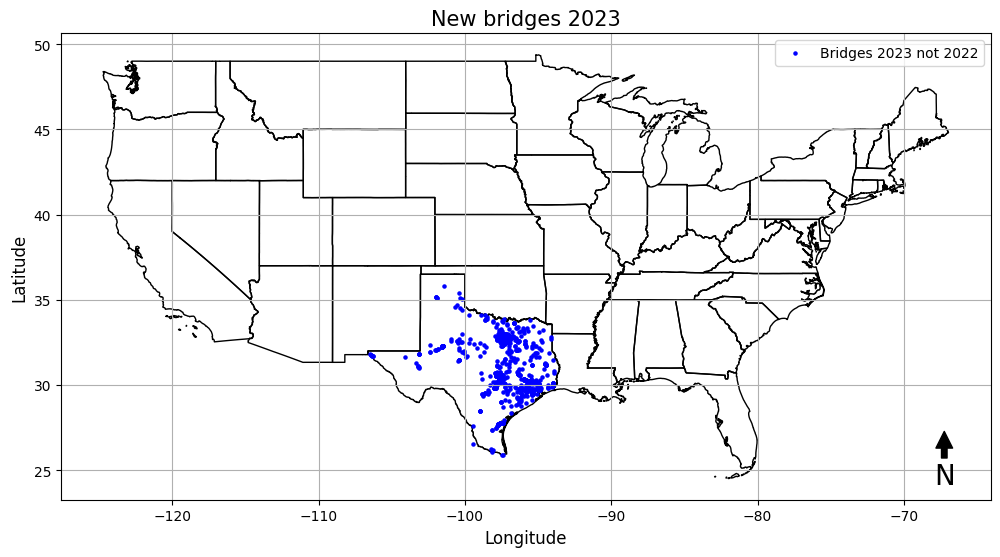

In [170]:
# Plotting the map
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, color='blue', marker='o', markersize=1,)

# Plot the Conus83 map as the base layer
map_gdf.plot(ax=ax, linewidth=1, edgecolor='black', facecolor='none')

# Plot the bridges on top of the map
gdf.plot(ax=ax, color='blue', marker='o', markersize=5, label='Bridges 2023 not 2022')

# Customize the map
ax.set_title('New bridges 2023', fontsize=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
plt.legend()
plt.grid(True)

# Add a north arrow
x, y, arrow_length = 0.95, 0.15, 0.1  # Position and length of the arrow (in axis coordinates)
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', shrink=0.05),
            ha='center', va='center', fontsize=20, xycoords='axes fraction')

# Display the plot
plt.show()

In [176]:
!pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [177]:
# Load datasets (simulated data as provided earlier)
tx_2022 = pd.DataFrame({
    "STRUCTURE_NUMBER_008": [1, 2, 3],
    "AGE": [50, 60, 45],
    "TRAFFIC_LANES_ON_028A": [2, 4, 2],
    "ADT_029": [1000, 2500, 400],
    "BRIDGE_CONDITION": [0, 1, 0]})

tx_2023 = pd.DataFrame({
    "STRUCTURE_NUMBER_008": [1, 2, 4],
    "AGE": [51, 61, 20],
    "TRAFFIC_LANES_ON_028A": [2, 4, 3],
    "ADT_029": [1100, 2550, 1500],
    "BRIDGE_CONDITION": [0, 1, 0]
})

# Merge datasets on the structure number
merged_bridges = pd.merge(tx_2023, tx_2022, on='STRUCTURE_NUMBER_008', how='left', suffixes=('_2023', '_2022'))

# Select features and target variable for logistic regression
features = ['AGE_2023', 'TRAFFIC_LANES_ON_028A_2023', 'ADT_029_2023']
X = merged_bridges[features]
y = merged_bridges['BRIDGE_CONDITION_2023']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and fit the logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Predict probabilities
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]
print("Predicted probabilities:", y_pred_prob)

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Predicted probabilities: [5.27065003e-09]
